# 1. Collision Detection Using Grover's Algorithm

1) Initializing the system:

In [15]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit import transpile

n = 3
solution = '101' #for bonus challenge, to generalise the problem

qc = QuantumCircuit(n, n)
qc.h(range(n))

2) The Oracle

In [16]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

3) The Diffusion Operator 

In [17]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

4) Performing Grover interations

In [18]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(2**n)))

def grover_amplitudes(n, solution, iterations):
    sol_idx = int(solution, 2)

    oracle   = grover_oracle(n, solution)
    diffuser = grover_diffuser(n)

    sv = Statevector.from_label('0'*n)
    sv = sv.evolve(qc)

    amps = [abs(sv.data[sol_idx])]

    for _ in range(iterations):
        sv = sv.evolve(oracle)
        sv = sv.evolve(diffuser)
        amps.append(abs(sv.data[sol_idx]))

    return amps

def grover_counts(n,solution, iterations):

    oracle   = grover_oracle(n, solution)
    diffuser = grover_diffuser(n)

    for _ in range(iterations):
        qc.append(oracle,   range(n))
        qc.append(diffuser, range(n))
    qc.measure(range(n), range(n))                 

    backend = AerSimulator()
    shots = 2048

    transpiled_qc = transpile(qc, backend)

    result = backend.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts(transpiled_qc)
    return counts

amps = grover_amplitudes(n, solution, iterations)
counts = grover_counts(n, solution, iterations)

5) Measuring the Final State

In [19]:
print(counts)

{'101': 1944, '110': 19, '000': 10, '010': 16, '100': 14, '001': 11, '011': 21, '111': 13}


6) Visualisation

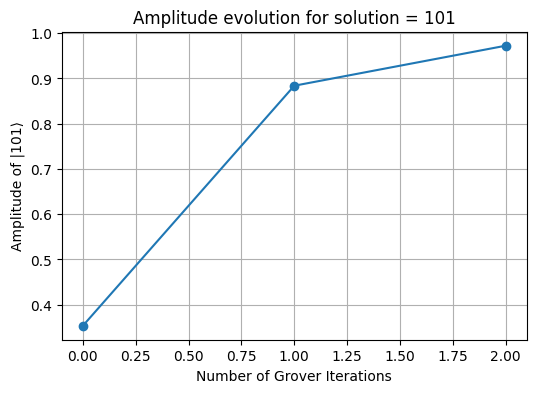

In [20]:
plt.figure(figsize=(6,4))
plt.plot(range(len(amps)), amps, 'o-')
plt.xlabel('Number of Grover Iterations')
plt.ylabel('Amplitude of |{}⟩'.format(solution))
plt.title(f'Amplitude evolution for solution = {solution}')
plt.grid(True)
plt.show()

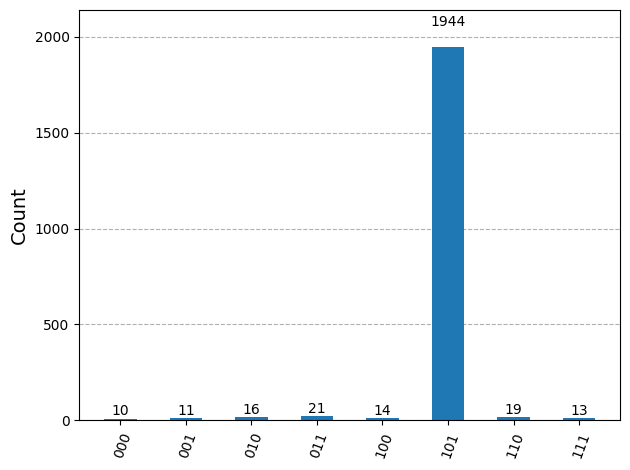

In [21]:
plot_histogram(counts)

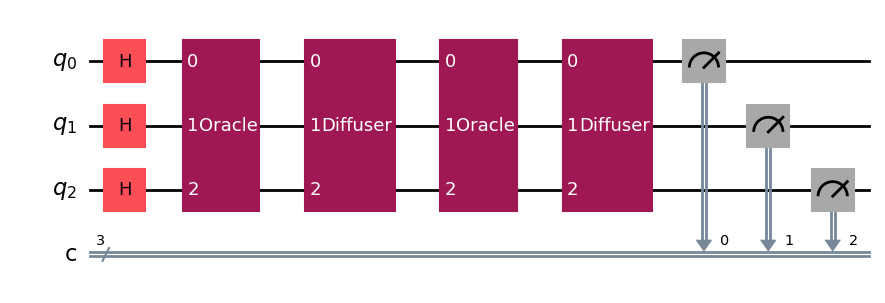

In [22]:
qc.draw('mpl')

# 2. Solving a 3-SAT Problem Using Grover's Algorithm

1) Problem Encoding

In [23]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import PhaseOracle
import itertools

formula = "(x1 |  ~x2 | x3) & (~x1 | x2 | x3)"

oracle = PhaseOracle(formula)
oracle.name = "Oracle"

2) Circuit Preparation

In [24]:
qc = QuantumCircuit(n, n)
qc.h(range(n))

n = oracle.num_qubits

def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) 
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

3) Number of Iterations

We are manually finding out the number of solutions (M) that satisifies our boolean expression.

In [25]:
M=0

def sat3(x):
    x1, x2, x3 = x
    clause1 = (x1 == 1) or (x2 == 0) or (x3 == 1)
    clause2 = (x1 == 0) or (x2 == 1) or (x3 == 1)
    return int(clause1 and clause2)

for bits in itertools.product([0,1], repeat=n):
    if sat3(bits) == 1:
        M += 1

iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt((2**n)/(M))))

print(iterations)

0


Here, M = 6 and hence we are getting number of Grover iterations as 0. This is because the probability of a good state is already very high, so the optimal number of reflections needed is zero.

4) Measurement

In [26]:
diffuser = grover_diffuser(n)

for _ in range(iterations):
        qc.append(oracle,   range(n))
        qc.append(diffuser, range(n))

qc.measure(range(n), range(n))                 
backend = AerSimulator()
shots = 2048

transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)

print(counts)

{'011': 255, '110': 255, '001': 269, '111': 255, '101': 255, '000': 263, '100': 257, '010': 239}


5. Result Validation

Except '010' and '100' all other possible bitstrings satsfies the 3-SAT formula.

6) Visualization

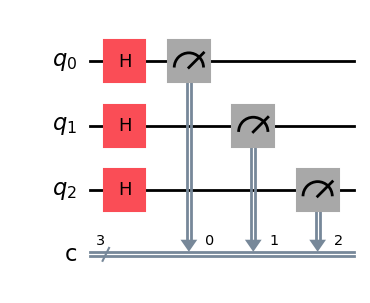

In [27]:
qc.draw('mpl')

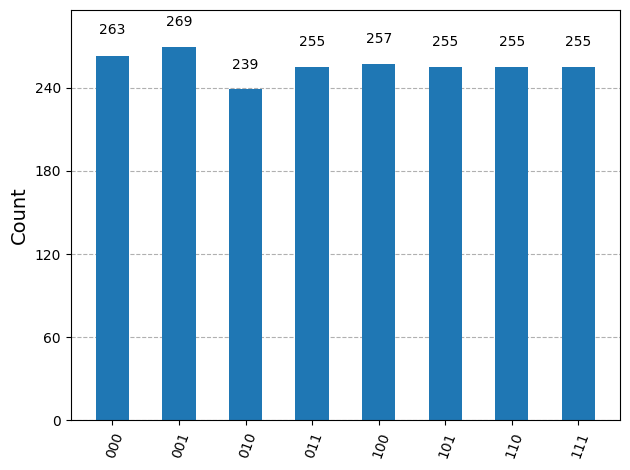

In [28]:
plot_histogram(counts)